In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import category_encoders as ce

# import lightgbm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

In [ ]:
data = pd.read_parquet("/content/drive/MyDrive/ParquetFile/store_CA_1_data.parquet")

In [ ]:
data.head()

,sales_id,date_id,item_id,store_id,units_sold,revenue,dept_id,cat_id,item_name,price,...,day_of_month,day_name,month,year,week_id,event_name,event_type,snap_CA,snap_TX,snap_WI
0,14787653,2012-05-28,HOBBIES_1_003,CA_1,0,0.00,HOBBIES_1,HOBBIES,HOBBIES_1_003,2.97,...,d_486,Wednesday,5,2012,11218,MemorialDay,National,0,0,0
1,14787671,2012-05-28,HOBBIES_1_021,CA_1,0,0.00,HOBBIES_1,HOBBIES,HOBBIES_1_021,11.81,...,d_486,Wednesday,5,2012,11218,MemorialDay,National,0,0,0
2,14787673,2012-05-28,HOBBIES_1_023,CA_1,3,10.20,HOBBIES_1,HOBBIES,HOBBIES_1_023,3.42,...,d_486,Wednesday,5,2012,11218,MemorialDay,National,0,0,0
3,14787698,2012-05-28,HOBBIES_1_048,CA_1,6,2.88,HOBBIES_1,HOBBIES,HOBBIES_1_048,0.47,...,d_486,Wednesday,5,2012,11218,MemorialDay,National,0,0,0
4,14787705,2012-05-28,HOBBIES_1_055,CA_1,0,0.00,HOBBIES_1,HOBBIES,HOBBIES_1_055,8.47,...,d_486,Wednesday,5,2012,11218,MemorialDay,National,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5832737 entries, 0 to 5832736
Data columns (total 27 columns):
 #   Column        Dtype  
---  ------        -----  
 0   sales_id      int64  
 1   date_id       object 
 2   item_id       object 
 3   store_id      object 
 4   units_sold    int64  
 5   revenue       float64
 6   dept_id       object 
 7   cat_id        object 
 8   item_name     object 
 9   price         float64
 10  store_name    object 
 11  store_type    object 
 12  store_size    int64  
 13  state_id      object 
 14  state_name    object 
 15  region        object 
 16  weekday       object 
 17  day_of_month  object 
 18  day_name      object 
 19  month         int64  
 20  year          int64  
 21  week_id       int64  
 22  event_name    object 
 23  event_type    object 
 24  snap_CA       int64  
 25  snap_TX       int64  
 26  snap_WI       int64  
dtypes: float64(2), int64(9), object(16)
memory usage: 1.2+ GB


In [ ]:
# Ensure date_id is datetime type and extract time-based features if not already done
data['date_id'] = pd.to_datetime(data['date_id'])
data['day_of_week'] = data['date_id'].dt.dayofweek
data['day_of_year'] = data['date_id'].dt.dayofyear

In [ ]:
data = data.sort_values(["item_id", "date_id"])

In [ ]:
for lag in [1, 7, 28]:
    data[f'lag_{lag}'] = data.groupby('item_id')['units_sold'].shift(lag)

In [ ]:
data['rolling_7'] = (
    data.groupby('item_id')['units_sold']
        .shift(1)
        .rolling(7)
        .mean()
        .reset_index(level=0, drop=True)
)
data['rolling_28'] = (
    data.groupby('item_id')['units_sold']
        .shift(1)
        .rolling(28)
        .mean()
        .reset_index(level=0, drop=True)
)
data['rolling_std_7'] = (
    data.groupby('item_id')['units_sold']
        .shift(1)
        .rolling(7)
        .std()
        .reset_index(level=0, drop=True)
)

In [ ]:
data['price_change_1'] = data.groupby('item_id')['price'].diff(1)
data['price_change_7'] = data.groupby('item_id')['price'].diff(7)

In [ ]:
data['event_window_7'] = (
    data.groupby('item_id')['event_name']
        .transform(lambda x: x.notna().astype(int)
        .rolling(7).sum())
)


In [ ]:
data = data.dropna().reset_index(drop=True)

In [ ]:
# lưu data ra file

data.to_parquet(
    "/content/drive/MyDrive/ParquetFile/model_data.parquet")

## Train

In [ ]:
data = pd.read_parquet("/content/drive/MyDrive/ParquetFile/model_data.parquet")

In [ ]:
train = data[data['date_id'] < '2016-04-01']
test  = data[data['date_id'] >= '2016-04-01']

y_train = train['units_sold']
y_test = test['units_sold']

In [ ]:
base_features = [
    'price', 'day_of_week', 'day_of_year', 'month', 'year',
    'store_id', 'item_id', 'dept_id', 'cat_id',
    'weekday', 'event_name', 'event_type'
]

lag_features = [f'lag_{lag}' for lag in [1, 7, 28]]
rolling_features = ['rolling_7', 'rolling_28', 'rolling_std_7']
price_features = ['price_change_1', 'price_change_7']
event_features = ['event_window_7']

features = (
    base_features
    + lag_features
    + rolling_features
    + price_features
    + event_features
)

In [ ]:
cat_cols = ['store_id', 'item_id', 'dept_id', 'cat_id', 'weekday',
            'event_name', 'event_type']

encoder = ce.TargetEncoder(cols=cat_cols)

X_train = encoder.fit_transform(train[features], y_train)
X_test = encoder.transform(test[features])

X_train.head()

,price,day_of_week,day_of_year,month,year,store_id,item_id,dept_id,cat_id,weekday,...,event_type,lag_1,lag_7,lag_28,rolling_7,rolling_28,rolling_std_7,price_change_1,price_change_7,event_window_7
0,2.17,5,57,2,2011,1.320757,0.771662,1.378406,1.959165,1.659859,...,1.327807,4.0,1.0,3.0,1.000000,0.928571,1.414214,0.0,0.0,7.0
1,2.17,6,58,2,2011,1.320757,0.771662,1.378406,1.959165,1.682341,...,1.327807,2.0,2.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,7.0
2,2.17,0,59,2,2011,1.320757,0.771662,1.378406,1.959165,1.266034,...,1.327807,2.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,7.0
3,2.17,1,60,3,2011,1.320757,0.771662,1.378406,1.959165,1.121037,...,1.327807,0.0,2.0,1.0,1.142857,1.035714,0.690066,0.0,0.0,7.0
4,2.17,2,61,3,2011,1.320757,0.771662,1.378406,1.959165,1.092399,...,1.327807,2.0,2.0,4.0,0.000000,0.000000,0.000000,0.0,0.0,7.0


### Split the data into training and testing sets

In [1]:
print(f"Training set size: {X_train.shape[0]} rows")
print(f"Testing set size: {X_test.shape[0]} rows")

NameError: name 'X_train' is not defined

### Train the LightGBM Regressor model

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model_lgbm = lgb.LGBMRegressor(
    objective='tweedie',
    tweedie_variance_power=1.5,
    num_leaves=128,
    learning_rate=0.05,
    n_estimators=1500,
    max_depth=-1,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    min_data_in_leaf=200,
    reg_alpha=1.0,
    reg_lambda=2.0,
    max_bin=255,
    device_type="gpu"
)

model_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing row-wise multi-threadi

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
              learning_rate=0.05, max_bin=255, min_data_in_leaf=200,
              n_estimators=1500, num_leaves=128, objective='tweedie',
              reg_alpha=1.0, reg_lambda=2.0, tweedie_variance_power=1.1)

## Evaluate the LightGBM model's performance on the training set

In [ ]:
y_pred_lgbm_train = model_lgbm.predict(X_train)

mse_train = mean_squared_error(y_train, y_pred_lgbm_train)
mae_train = mean_absolute_error(y_train, y_pred_lgbm_train)
r2_train = r2_score(y_train, y_pred_lgbm_train)

print(f"Mean Squared Error (MSE) on training set: {mse_train:.4f}")
print(f"Mean Absolute Error (MAE) on training set: {mae_train:.4f}")
print(f"R-squared (R2) on training set: {r2_train:.4f}")

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Limit the number of points to plot for better readability if the training set is very large
n_points_train = 500

plt.figure(figsize=(15, 7))
plt.plot(y_train.values[:n_points_train], label='Actual Units Sold (Train)', color='green', alpha=0.7)
plt.plot(y_pred_lgbm_train[:n_points_train], label='Predicted Units Sold (Train)', color='purple', alpha=0.7, linestyle='--')

plt.title('Comparison of Actual vs. Predicted Units Sold on Training Set (First ' + str(n_points_train) + ' Points)')
plt.xlabel('Data Point Index')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()

## Plot Actual vs. Predicted Units Sold on the test set

In [ ]:
y_pred_lgbm = model_lgbm.predict(X_test)


mse = mean_squared_error(y_test, y_pred_lgbm)
mae = mean_absolute_error(y_test, y_pred_lgbm)
r2 = r2_score(y_test, y_pred_lgbm)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Mean Squared Error (MSE): 4.2494
Mean Absolute Error (MAE): 1.0950
R-squared (R2): 0.6610


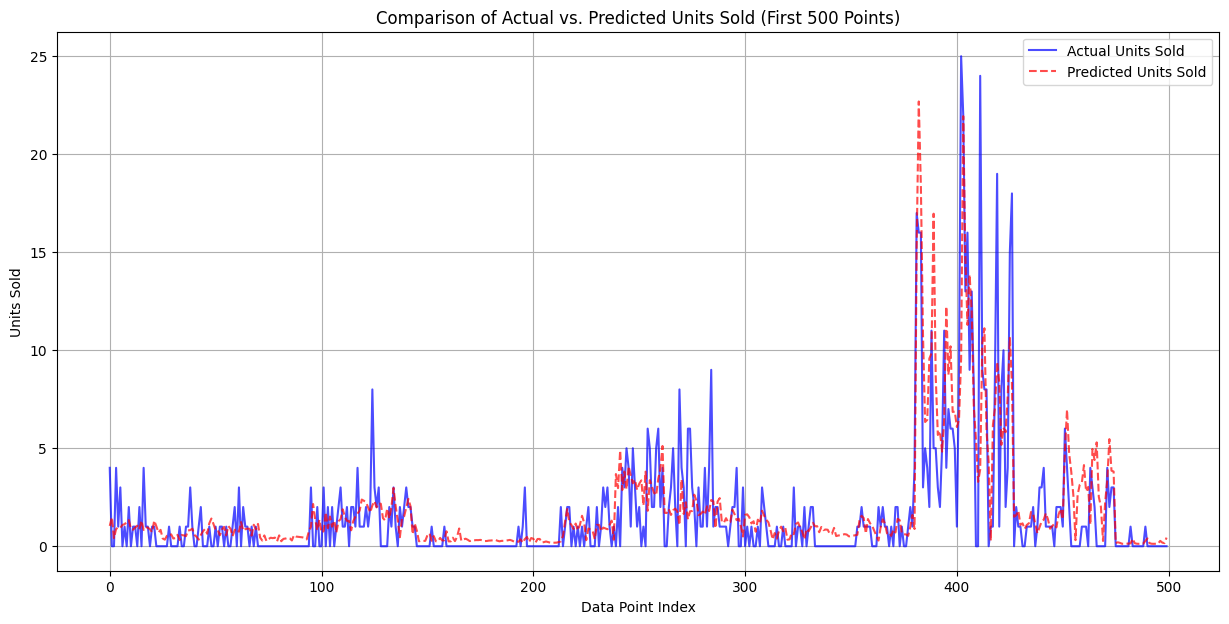

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Limit the number of points to plot for better readability if the test set is very large
# For example, plotting the first 500 points
n_points = 500

plt.figure(figsize=(15, 7))
plt.plot(y_test.values[:n_points], label='Actual Units Sold', color='blue', alpha=0.7)
plt.plot(y_pred_lgbm[:n_points], label='Predicted Units Sold', color='red', alpha=0.7, linestyle='--')

plt.title('Comparison of Actual vs. Predicted Units Sold (First ' + str(n_points) + ' Points)')
plt.xlabel('Data Point Index')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Lưu mô hình
import joblib

model_save_path = '/content/drive/MyDrive/lgbm_prediction_model_tweedie.joblib'
joblib.dump(model_lgbm, model_save_path)

print(f"Mô hình đã được lưu tại: {model_save_path}")

Mô hình đã được lưu tại: /content/drive/MyDrive/lgbm_prediction_model_tweedie.joblib


# Task
Evaluate the LightGBM model by loading the saved model from `/content/drive/MyDrive/lgbm_prediction_model2.joblib`, making predictions on `X_test`, calculating the Root Mean Squared Scaled Error (RMSSE) using `y_train` for scaling, and displaying the RMSSE.

## Load Model

### Subtask:
Tải mô hình LightGBM đã được lưu từ đường dẫn '/content/drive/MyDrive/lgbm_prediction_model2.joblib' bằng cách sử dụng `joblib.load()`.


**Reasoning**:
Load the saved LightGBM model from the specified path using `joblib.load()`.



In [ ]:
import joblib

model_path = '/content/drive/MyDrive/lgbm_prediction_model_tweedie.joblib'
loaded_model = joblib.load(model_path)

print(f"LightGBM model loaded successfully from: {model_path}")

LightGBM model loaded successfully from: /content/drive/MyDrive/lgbm_prediction_model_tweedie.joblib


**Reasoning**:
Now that the model is loaded, the next step is to make predictions on the test set (`X_test`) using the `loaded_model`. This will provide the predicted values for calculating evaluation metrics.



In [ ]:

y_pred_loaded = loaded_model.predict(X_test)

print("Predictions on X_test made successfully.")

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Predictions on X_test made successfully.


**Reasoning**:
With `y_test`, `y_pred_loaded`, and `y_train` now defined, I can proceed to calculate the Root Mean Squared Scaled Error (RMSSE). This involves calculating the mean squared error of the predictions on the test set and scaling it by the mean squared error of a naive forecast on the training set. I need to handle potential division by zero if the training naive forecast error is zero.



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Giả định y_test và y_pred_loaded đã được định nghĩa
# y_test là giá trị thực tế, y_pred_loaded là giá trị dự đoán từ mô hình LightGBM

# --- 1. CÁC CHỈ SỐ HỒI QUY CƠ BẢN ---

# 1.1. Mean Squared Error (MSE)
mse_test = mean_squared_error(y_test, y_pred_loaded)
print(f"Mean Squared Error (MSE): {mse_test:.4f}")

# 1.2. Root Mean Squared Error (RMSE)
rmse_test = np.sqrt(mse_test)
print(f"Root Mean Squared Error (RMSE): {rmse_test:.4f}")

# 1.3. Mean Absolute Error (MAE)
mae_test = mean_absolute_error(y_test, y_pred_loaded)
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")

# 1.4. R-squared (R2 Score)
r2 = r2_score(y_test, y_pred_loaded)
print(f"R-squared (R2 Score): {r2:.4f}")

# 1.5. Mean Absolute Percentage Error (MAPE)
# Lưu ý: Tránh chia cho 0. MAPE chỉ phù hợp khi giá trị thực tế (y_test) không có hoặc ít giá trị 0.
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Loại bỏ các giá trị y_true = 0 để tránh lỗi chia cho 0
    non_zero_indices = y_true != 0
    if np.any(non_zero_indices):
        mape = np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100
        return mape
    else:
        return np.nan # Hoặc trả về giá trị khác nếu tất cả y_true đều bằng 0

mape_test = mean_absolute_percentage_error(y_test, y_pred_loaded)
if not np.isnan(mape_test):
    print(f"Mean Absolute Percentage Error (MAPE): {mape_test:.2f}%")
else:
    print("Mean Absolute Percentage Error (MAPE): Không thể tính (tất cả giá trị thực tế bằng 0).")


# --- 2. CHỈ SỐ RMSSE (Đã có trong code gốc, được tích hợp) ---
print("\n--- Chỉ số đặc thù cho Chuỗi thời gian ---")

# Tính toán sai số bình phương cho dự báo ngây thơ (naive forecast) trên tập huấn luyện (y_train)
# Giả sử y_train là Series Pandas đã được định nghĩa
diff_y_train = y_train.diff().dropna()

if len(diff_y_train) > 0:
    scale_factor = (diff_y_train**2).mean()
else:
    scale_factor = 0

# Tính RMSSE
if scale_factor > 0:
    rmsse = np.sqrt(mse_test / scale_factor)
    print(f"Root Mean Squared Scaled Error (RMSSE): {rmsse:.4f}")
else:
    print("Cannot compute RMSSE: Scale factor (naive forecast error on training set) is zero or undefined.")
    print(f"MSE Test: {mse_test:.4f}")
    print(f"Scale Factor (Naive Forecast MSE on Training): {scale_factor:.4f}")
# 1.6. Weighted Mean Absolute Percentage Error (WMAPE)
def weighted_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    sum_abs_error = np.sum(np.abs(y_true - y_pred))
    sum_abs_true = np.sum(np.abs(y_true))

    if sum_abs_true != 0:
        return sum_abs_error / sum_abs_true
    else:
        return np.nan

wmape_test = weighted_mean_absolute_percentage_error(y_test, y_pred_loaded)
print(f"Weighted Mean Absolute Percentage Error (WMAPE): {wmape_test:.4f} (hay {wmape_test*100:.2f}%)")

Mean Squared Error (MSE): 4.2494
Root Mean Squared Error (RMSE): 2.0614
Mean Absolute Error (MAE): 1.0950
R-squared (R2 Score): 0.6610
Mean Absolute Percentage Error (MAPE): 56.30%

--- Chỉ số đặc thù cho Chuỗi thời gian ---
Root Mean Squared Scaled Error (RMSSE): 0.7134
Weighted Mean Absolute Percentage Error (WMAPE): 0.7102 (hay 71.02%)
